In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

import jax.numpy as jnp
from jax import random, lax, jit, vmap

import numpyro
from numpyro.contrib.nested_sampling import NestedSampler
import numpyro.distributions as dist
from numpyro.handlers import block, condition
from numpyro.infer import MCMC, NUTS, init_to_value, log_likelihood

numpyro.enable_x64()

In [2]:
%run ../notebook_setup.py

In [3]:
# Load data
lc = np.loadtxt("lc.txt")
interp = np.loadtxt("interp.txt")
t, F, Ferr = lc
points, zeta_e, zeta_n, zeta_e_dot, zeta_n_dot = interp

In [4]:
def model(t, F, Ferr):
    DeltaF = numpyro.sample("DeltaF", dist.LogNormal(4.0, 4.0))
    Fbase = numpyro.sample("Fbase", dist.LogNormal(2.0, 4.0))
    t0 = numpyro.sample("t0", dist.Normal(3630.0, 50.0))
    tE = numpyro.sample("tE", dist.LogNormal(3.0, 6.0))
    u0 = numpyro.sample("u0", dist.Normal(0.0, 1.0))
    piEE = numpyro.sample("piEE", dist.Normal(0.0, 0.5))
    piEN = numpyro.sample("piEN", dist.Normal(0.0, 0.5))

    # Compute trajectory
    zeta_e_t = jnp.interp(t, points, zeta_e)
    zeta_n_t = jnp.interp(t, points, zeta_n)
    zeta_e_t0 = jnp.interp(t0, points, zeta_e)
    zeta_n_t0 = jnp.interp(t0, points, zeta_n)
    zeta_e_dot_t0 = jnp.interp(t0, points, zeta_e_dot)
    zeta_n_dot_t0 = jnp.interp(t0, points, zeta_n_dot)

    delta_zeta_e = zeta_e_t - zeta_e_t0 - (t - t0) * zeta_e_dot_t0
    delta_zeta_n = zeta_n_t - zeta_n_t0 - (t - t0) * zeta_n_dot_t0

    u_per = u0 + piEN * delta_zeta_e - piEE * delta_zeta_n
    u_par = (t - t0) / tE + piEE * delta_zeta_e + piEN * delta_zeta_n
    u = jnp.sqrt(u_per ** 2 + u_par ** 2)

    # Magnification
    A_u = (u ** 2 + 2) / (u * jnp.sqrt(u ** 2 + 4))
    A_u0 = (u0 ** 2 + 2) / (jnp.abs(u0) * jnp.sqrt(u0 ** 2 + 4))
    A = (A_u - 1) / (A_u0 - 1)
    F_pred = DeltaF * A + Fbase
    numpyro.deterministic("fpred", F_pred)

    ln_c = numpyro.sample("ln_c", dist.HalfNormal(2.0))
    numpyro.sample("data_dist", dist.Normal(F_pred, jnp.exp(ln_c) * Ferr), obs=F)

In [5]:
rand_key = random.PRNGKey(0)

In [6]:
samples_list = []
compare_dict = {}

start1 = {"t0": 3630.0, "u0": 0.5, "piEE": 0.1, "piEN": 0.3}
start2 = {"t0": 3630.0, "u0": -0.6}
start3 = {"t0": 3630.0, "u0": 0.25}
start4 = {"t0": 3630.0, "u0": -0.2, "piEE": 0.07, "piEN": 0.4}

init_vals = [start1, start2, start3, start4]

for i in range(len(init_vals)):
    u0test = np.random.uniform(-0.5, 0.5)
    mcmc = MCMC(
        NUTS(model, init_strategy=init_to_value(values=init_vals[i])),
        num_warmup=500,
        num_samples=4000,
        num_chains=1,
    )
    mcmc.run(rand_key, t, F, Ferr)
    data = az.from_numpyro(mcmc)
    compare_dict[f"chain_{i}"] = data
    loo = az.loo(data, pointwise=True)
    samples_list.append(mcmc.get_samples())

sample: 100%|██████████| 4500/4500 [00:24<00:00, 181.64it/s, 127 steps of size 2.37e-02. acc. prob=0.94]


In [7]:
%%time
ns = NestedSampler(model, num_live_points=3000, sampler_name='slice', max_samples=2e5, termination_frac=0.002,
                   sampler_kwargs=dict(depth=6, num_slices=4))
ns.run(random.PRNGKey(1), t, F, Ferr)

Number of weighted samples: 157067
Effective sample size: 22471.7
CPU times: user 2min 48s, sys: 3.72 s, total: 2min 52s
Wall time: 2min 53s


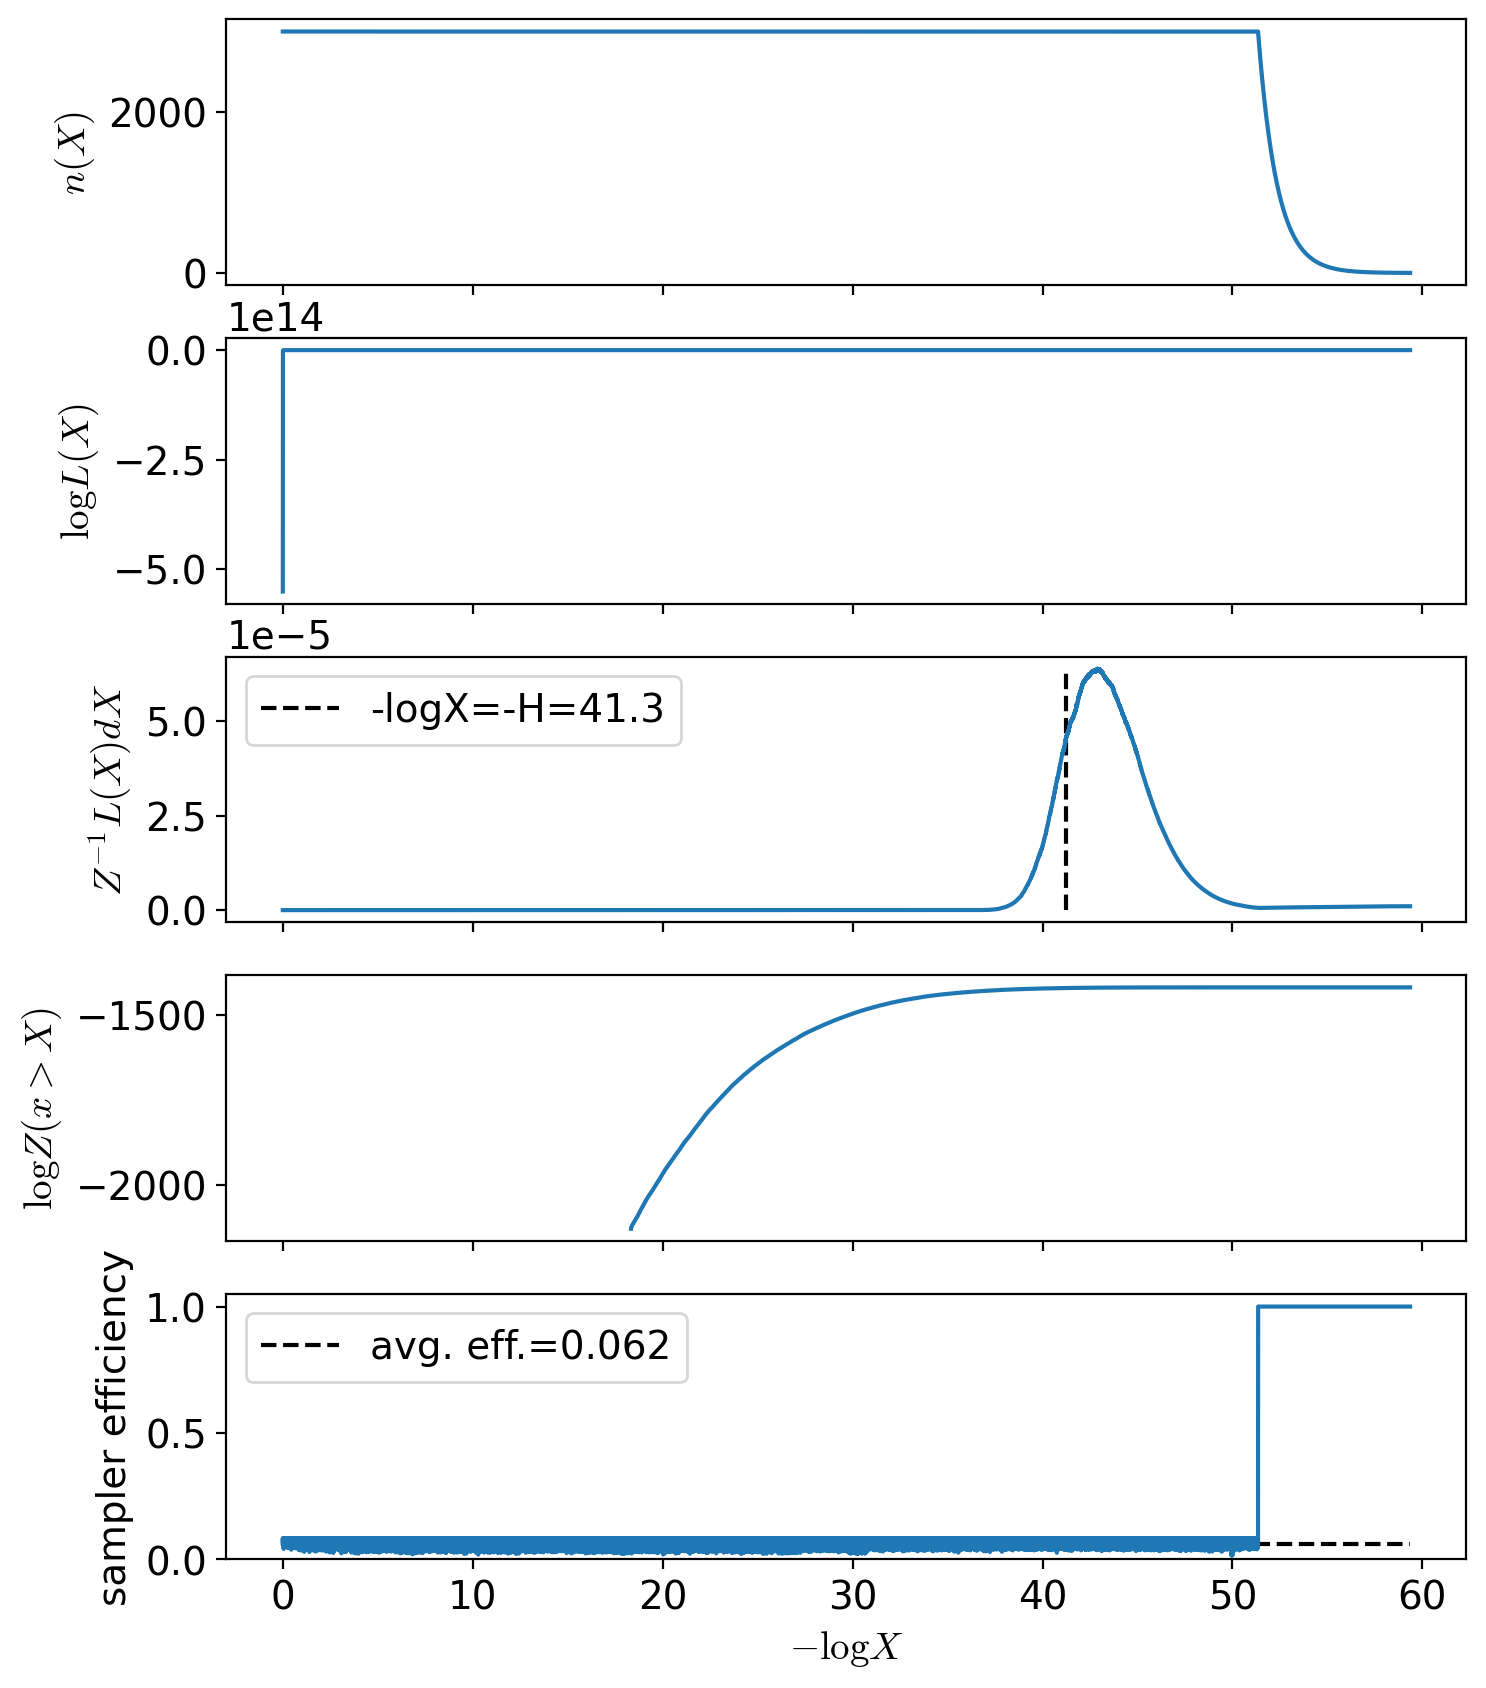

In [8]:
ns.diagnostics(cornerplot=False)  # cornerplot is slow

In [9]:
samples_jaxns = ns.get_samples(random.PRNGKey(1), 100000)

Text(0.5, 0, '$t_E$')

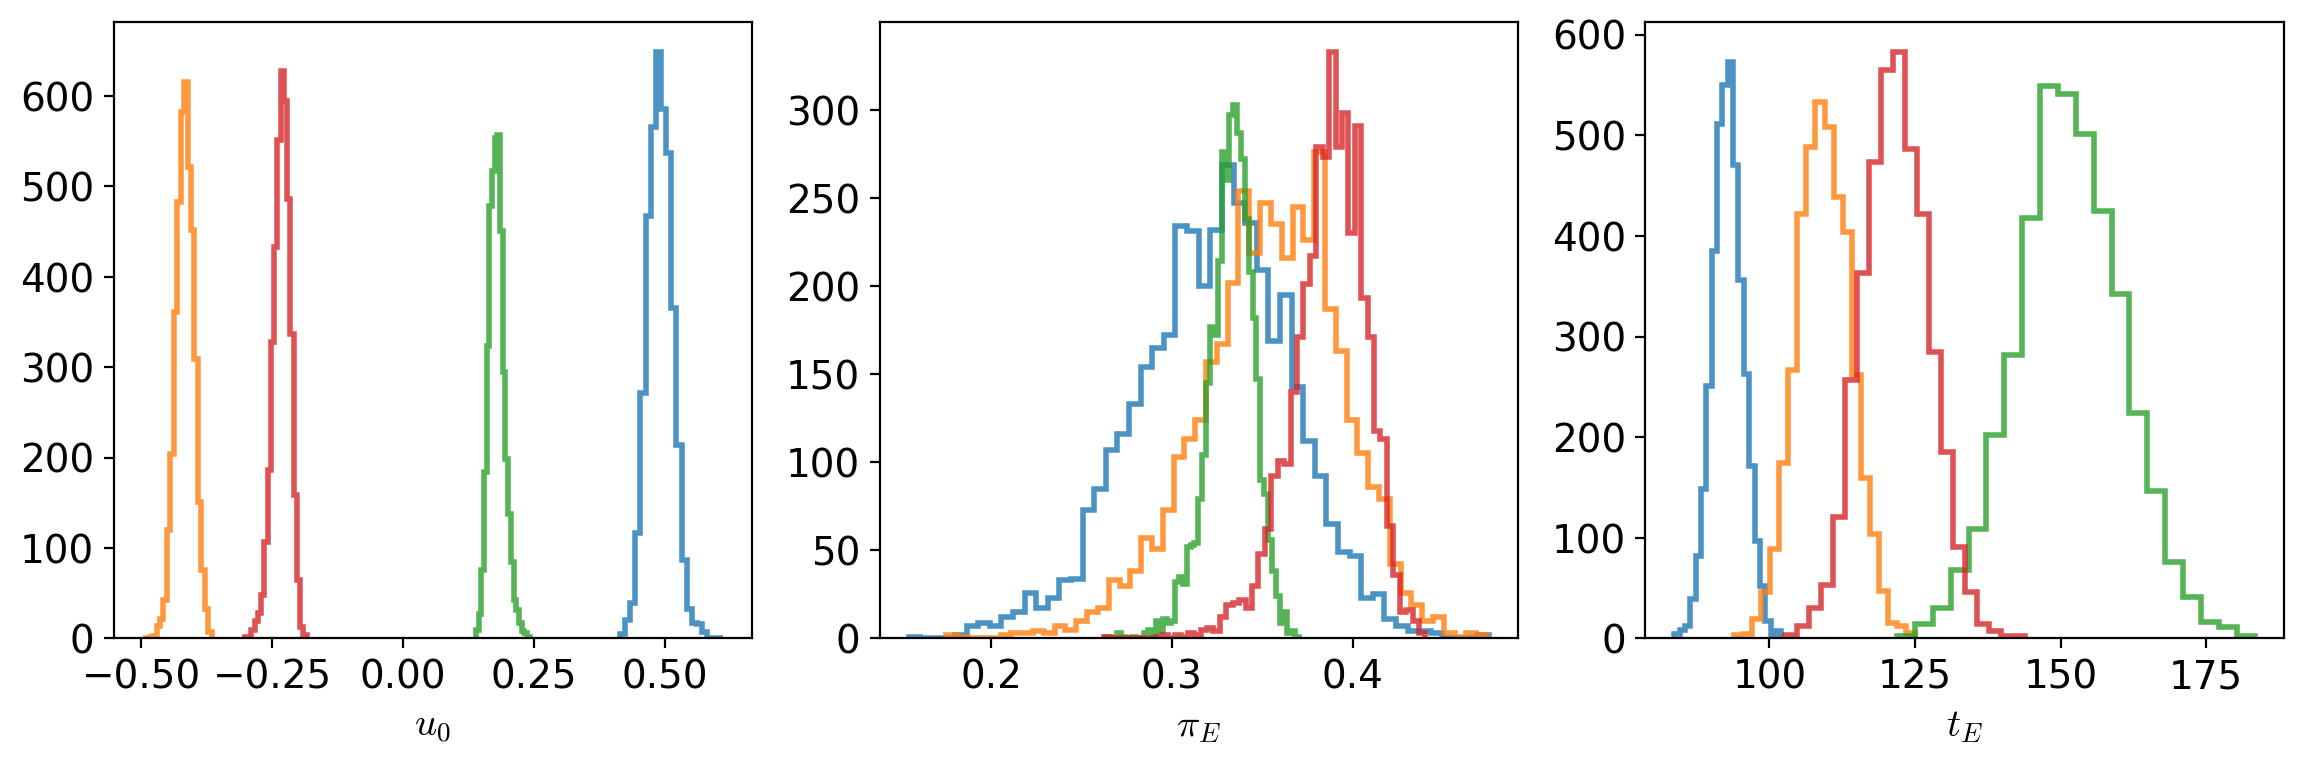

In [10]:
# Combine NUTS chains for each parameter
samples_combined = {}

varnames = list(samples_list[0].keys())
varnames.remove("fpred")

for var in varnames:
    l = []
    for s in samples_list:
        l.append(s[var])
    samples_combined[var] = np.stack(l).T

# Plot NUTS samples from different modes
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for s in samples_list:
    ax[0].hist(s["u0"], histtype="step", lw=2, bins=20, alpha=0.8)
    ax[1].hist(
        np.sqrt(s["piEN"] ** 2 + s["piEE"] ** 2),
        histtype="step",
        lw=2,
        bins=50,
        alpha=0.8,
    )
    ax[2].hist(s["tE"], histtype="step", lw=2, bins=20, alpha=0.8)

ax[0].set_xlabel("$u_0$")
ax[1].set_xlabel("$\pi_{E}$")
ax[2].set_xlabel("$t_E$")

In [11]:
# Compare modes with pseudo-BMA and stacking
df_bma = az.compare(compare_dict, method="BB-pseudo-BMA")
df_bma.sort_index(inplace=True)
weights_bma = df_bma["weight"].values.astype(np.float64)
loo = df_bma["loo"].values.astype(np.float64)
loo_se = df_bma["se"].values.astype(np.float64)

df_stack = az.compare(compare_dict, method="stacking")
df_stack.sort_index(inplace=True)
weights_stack = df_stack["weight"].values.astype(np.float64)

/Users/fb90/anaconda3/envs/caustic/lib/python3.8/site-packages/arviz-0.10.0-py3.8.egg/arviz/stats/stats.py:144: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/fb90/anaconda3/envs/caustic/lib/python3.8/site-packages/arviz-0.10.0-py3.8.egg/arviz/stats/stats.py:144: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


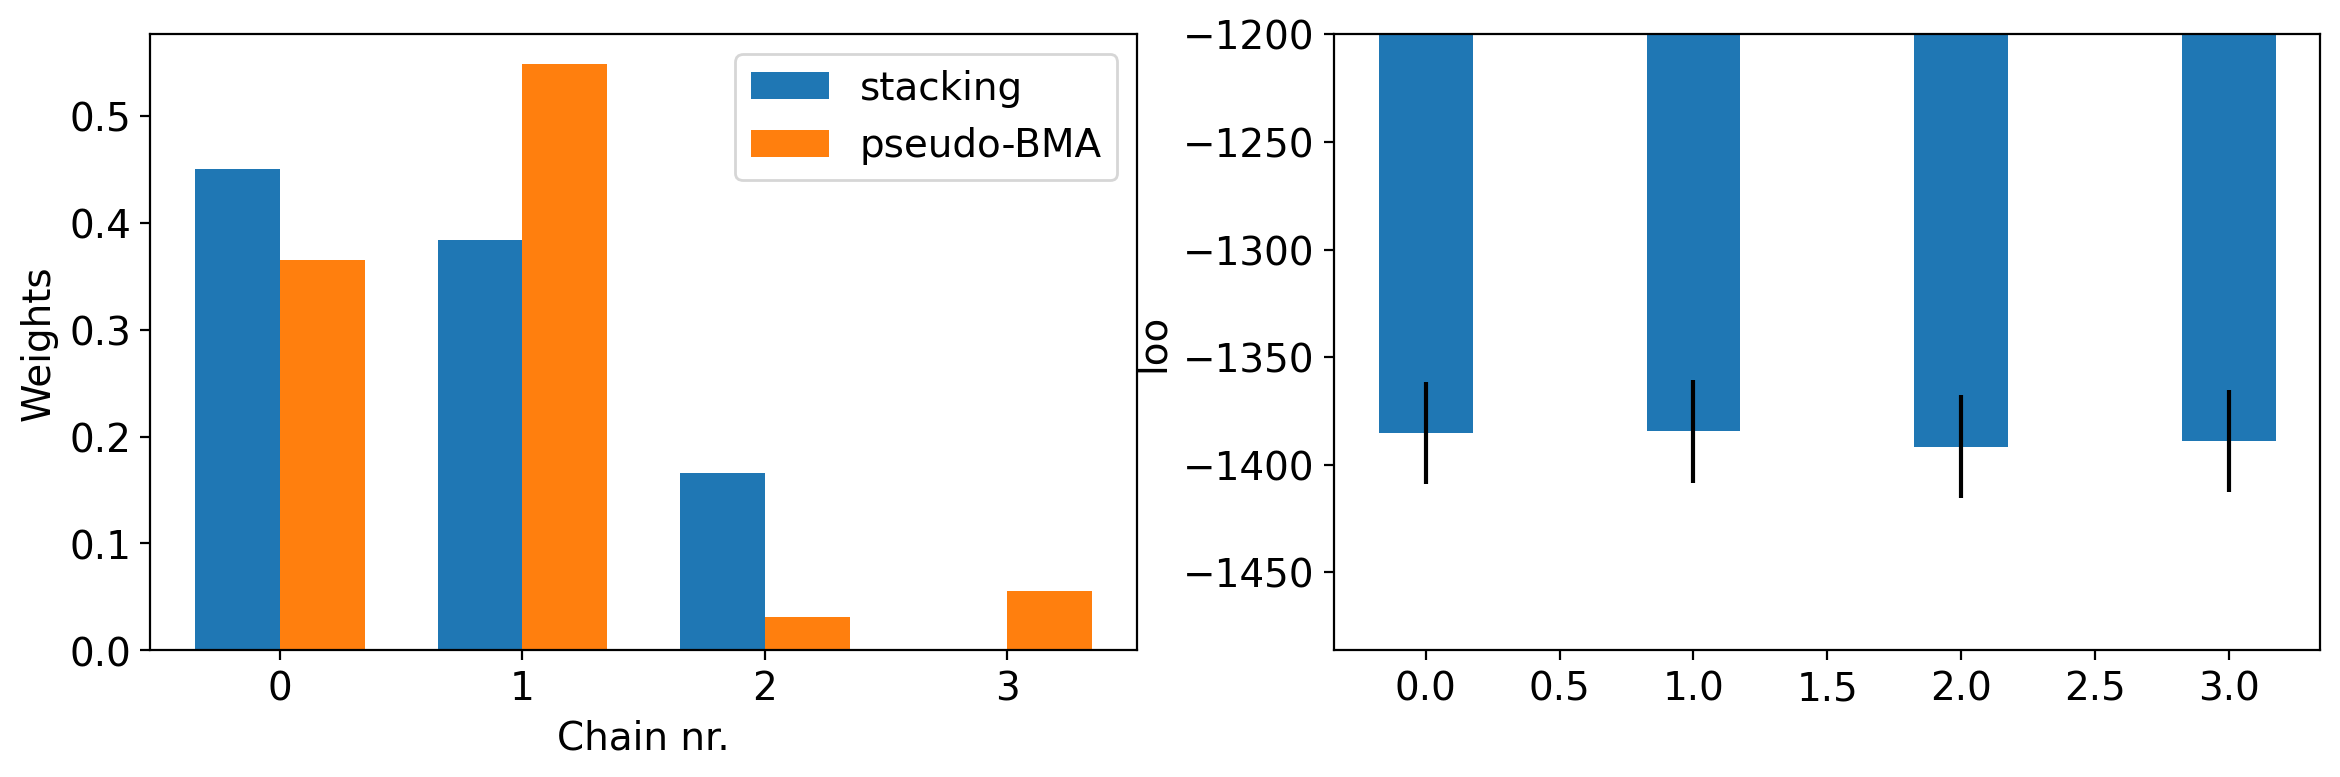

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
width = 0.35
x = np.arange(len(weights_stack))
ax[0].bar(x - width / 2, weights_stack, width, label="stacking")
ax[0].bar(x + width / 2, weights_bma, width, label="pseudo-BMA")
ax[0].set_xlabel("Chain nr.")
ax[1].bar(x, loo, width, yerr=loo_se, label="loo")
ax[1].set_ylim(top=-1200)

ax[0].set_ylabel("Weights")
ax[1].set_ylabel("loo")

ax[0].legend()

In [20]:
def mixture_draws(samples, weights, nthin=None, permutation=True):
    """
    Given samples from K mcmc chains and weights w_k, k=1..K, the function returns
    nthin simulation draws approximating the weighted mixture of K distributions.

    Adapted from https://github.com/yao-yl/Multimodal-stacking-code/blob/master/chain_stacking.R

    Args:
        samples (ndarray): Parameter samples from K chains, shape (nvar, nsamples, K).
        weights (ndarray): Size K array of weights.
        nthin (int): Number of samples after thining, if None samples won't be thinned. Defaults to None.
        permutation (bool): Randomly permute the samples. Defaults to True.
    Returns:
        ndarray: Samples from the mixture distribution, shape (nvar, nsamples).
    """
    dct = {}

    for varname in samples.keys():
        s = samples[varname]
        nsamples = s.shape[0]
        K = s.shape[1]

        if nthin is None:
            nthin = nsamples

        if permutation is True:
            s = np.random.permutation(s)

        integer_part = np.floor(nthin * weights).astype(np.int32)
        existing_draws = int(sum(integer_part))

        if existing_draws < nthin:
            remaining_draws = nthin - existing_draws
            update_w = (weights - integer_part / nthin) * nthin / remaining_draws
            remaining_assignment = np.random.choice(
                K, remaining_draws, p=update_w, replace=False
            )
            integer_part[remaining_assignment] = integer_part[remaining_assignment] + 1

        integer_part_index = np.insert(np.cumsum(integer_part), 0, 0, axis=0).astype(
            np.int32
        )
        mixture_vector = np.zeros(nthin)

        for k in range(K):
            if (1 + integer_part_index[k]) <= integer_part_index[k + 1]:
                mixture_vector[integer_part_index[k] : integer_part_index[k + 1]] = s[
                    : integer_part[k], k
                ]

        dct[varname] = mixture_vector

    return dct


draws = mixture_draws(samples_combined, weights_stack)

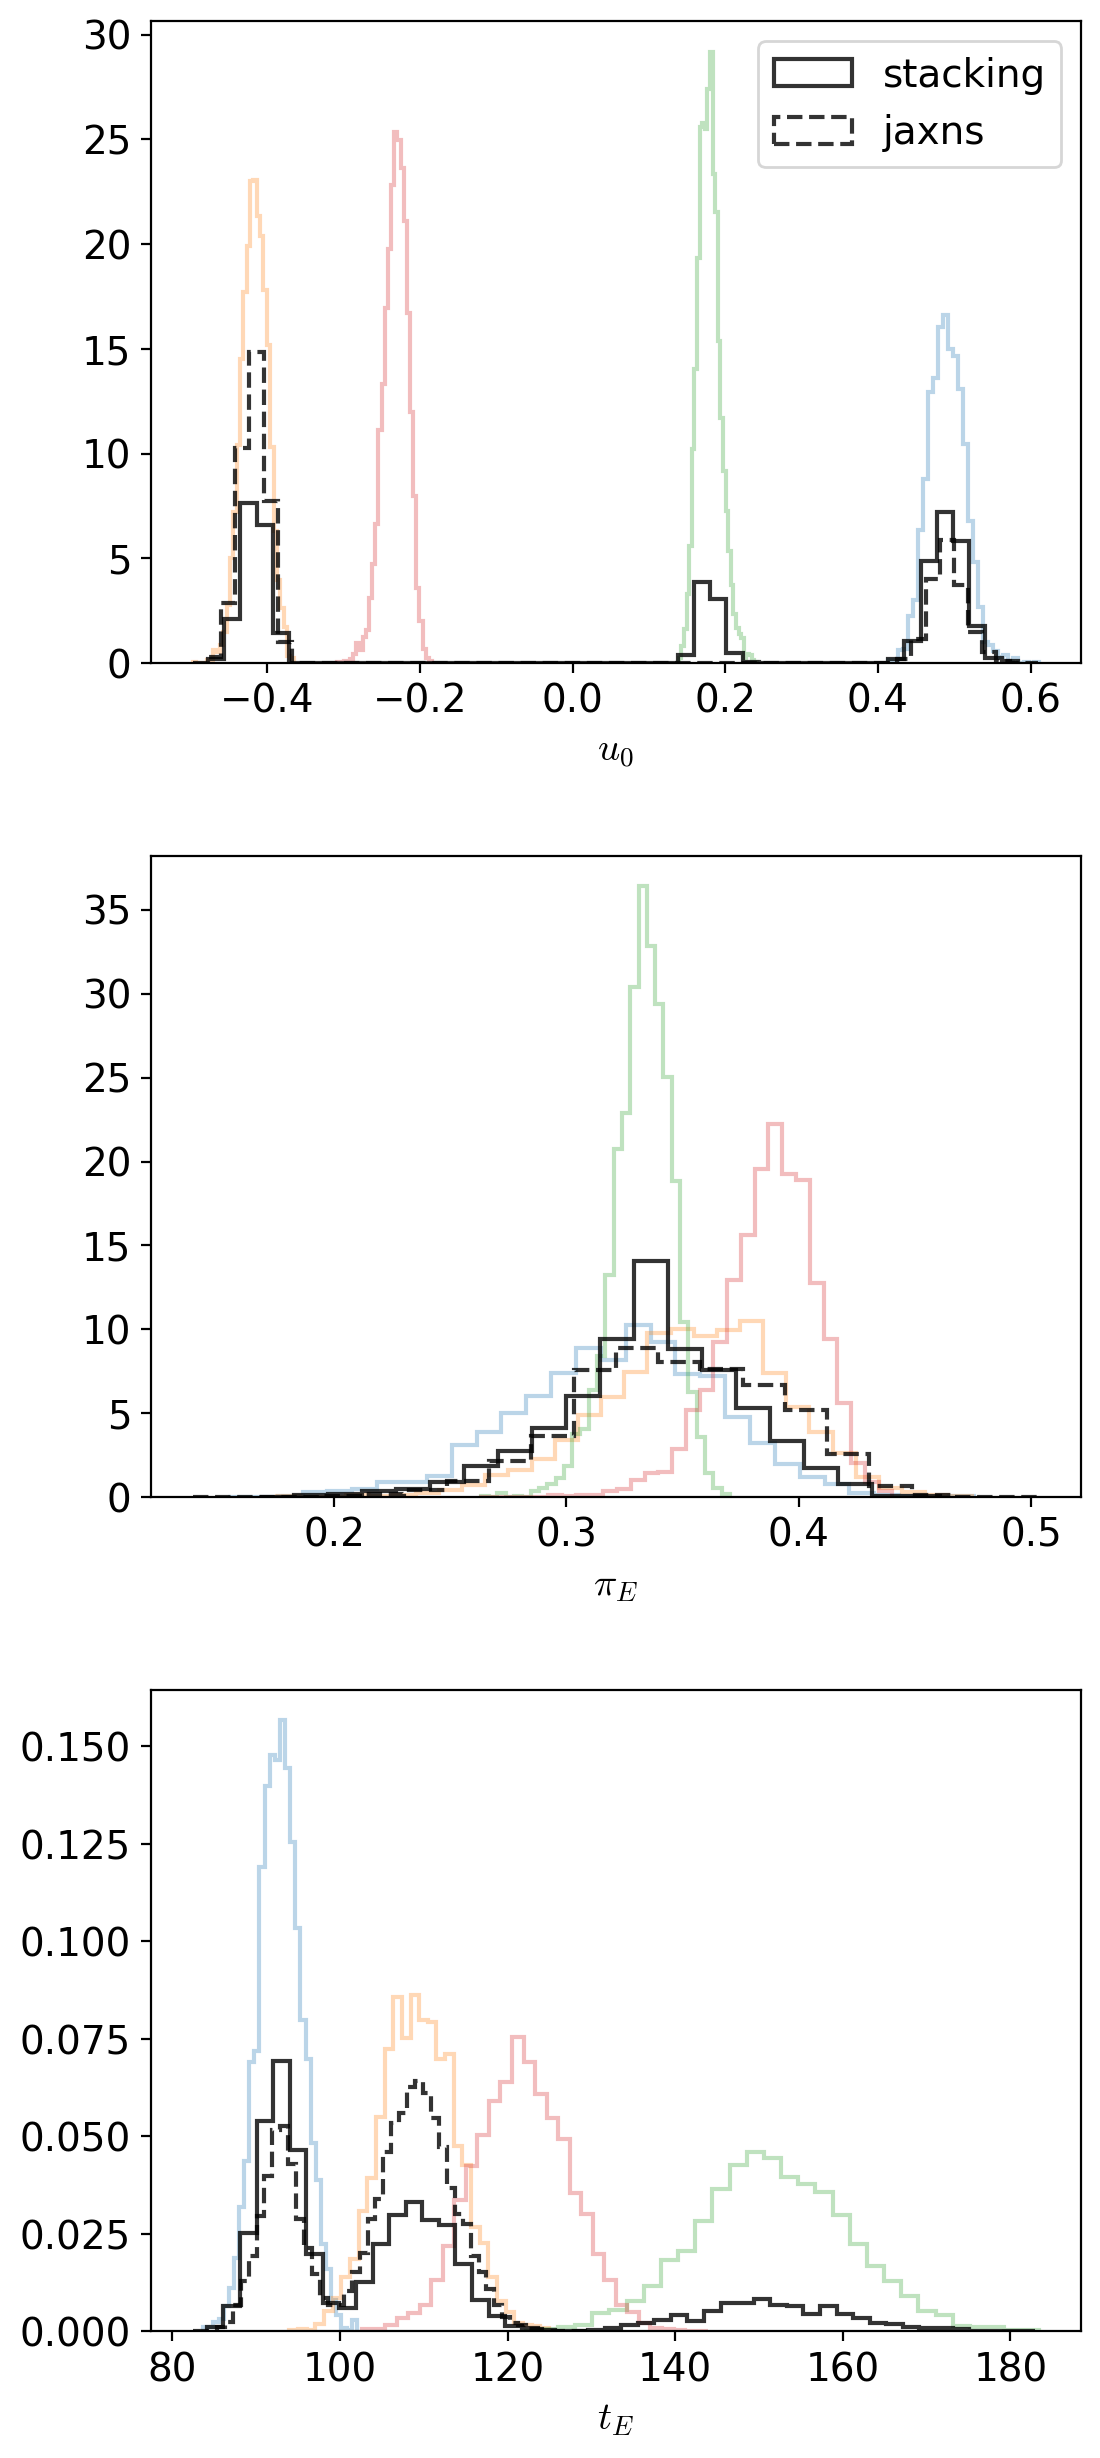

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(6, 15))
fig.subplots_adjust(hspace=0.3)
for s in samples_list:
    ax[0].hist(s["u0"], histtype="step", lw=1.5, bins=30, alpha=0.3, density=True)
    ax[1].hist(
        np.sqrt(s["piEN"] ** 2 + s["piEE"] ** 2),
        histtype="step",
        lw=1.5,
        bins=30,
        alpha=0.3,
        density=True,
    )
    ax[2].hist(s["tE"], histtype="step", lw=1.5, bins=30, alpha=0.3, density=True)

ax[0].hist(
    draws["u0"],
    histtype="step",
    lw=1.5,
    bins=50,
    alpha=0.8,
    color="black",
    density=True,
    label="stacking",
)
ax[1].hist(
    np.sqrt(draws["piEN"] ** 2 + draws["piEE"] ** 2),
    histtype="step",
    lw=1.5,
    bins=20,
    alpha=0.8,
    color="black",
    density=True,
    label="stacking",
)
ax[2].hist(
    draws["tE"],
    histtype="step",
    lw=1.5,
    bins=50,
    alpha=0.8,
    color="black",
    density=True,
)

ax[0].hist(
    samples_jaxns["u0"],
    histtype="step",
    lw=1.5,
    bins=60,
    alpha=0.8,
    color="black",
    density=True,
    linestyle="--",
    label="jaxns",
)
ax[1].hist(
    np.sqrt(samples_jaxns["piEN"] ** 2 + samples_jaxns["piEE"] ** 2),
    histtype="step",
    lw=1.5,
    bins=20,
    alpha=0.8,
    color="black",
    density=True,
    linestyle="--",
    label="jaxns",
)
ax[2].hist(
    samples_jaxns["tE"],
    histtype="step",
    lw=1.5,
    bins=50,
    alpha=0.8,
    color="black",
    density=True,
    linestyle="--",
    label="jaxns",
)


ax[0].set_xlabel("$u_0$")
ax[1].set_xlabel("$\pi_{E}$")
ax[2].set_xlabel("$t_E$")
ax[0].legend()